<a href="https://colab.research.google.com/github/Ewins518/AnomalieDetection/blob/main/anomalieDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1)
tf.random.set_seed(1)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.11.0


In [3]:
df = pd.read_csv('JPM.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-14,116.559998,116.589996,114.599998,114.949997,99.224884,12905100
2018-03-15,115.870003,116.000000,114.830002,115.239998,99.475212,8748000
2018-03-16,115.339996,116.599998,115.339996,115.440002,99.647858,19888900
2018-03-19,115.099998,115.449997,113.300003,114.529999,98.862343,13214900
2018-03-20,114.870003,115.449997,114.449997,114.639999,98.957291,9921200


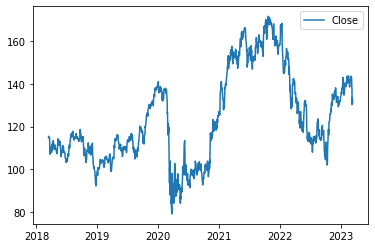

In [ ]:
plt.plot(df['Close'], label='Close')
plt.legend();

# Data Preprocessing

In [ ]:
# Use the 80% of the data to train our model
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

(1006, 6) (252, 6)


<ipython-input-11-bb8c86904b09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
<ipython-input-11-bb8c86904b09>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [ ]:
t = train[['Close']]

In [ ]:
def create_seq(X, y, time_steps=1):
  Xs, ys = [], []
  for i in range(len(X) - time_steps):
    v = X.iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(y.iloc[i + time_steps])
  return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 30
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_seq( train[['Close']],train.Close,TIME_STEPS)
X_test, y_test = create_seq(test[['Close']], test.Close,TIME_STEPS)
print(X_train.shape)

(976, 30, 1)


In [ ]:
y_train.shape

(976,)

# Bulid the model

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
units=64,
input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(
keras.layers.Dense(units=X_train.shape[2])
)
)
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(
X_train, y_train,
epochs=10,
batch_size=32,
validation_split=0.1,
shuffle=False
)

Epoch 1/10
28/28 [==============================] - 8s 78ms/step - loss: 0.3342 - val_loss: 0.3993
Epoch 2/10
28/28 [==============================] - 1s 45ms/step - loss: 0.3153 - val_loss: 0.2889
Epoch 3/10
28/28 [==============================] - 1s 44ms/step - loss: 0.2383 - val_loss: 0.3134
Epoch 4/10
28/28 [==============================] - 1s 44ms/step - loss: 0.2572 - val_loss: 0.2467
Epoch 5/10
28/28 [==============================] - 1s 44ms/step - loss: 0.2329 - val_loss: 0.2453
Epoch 6/10
28/28 [==============================] - 1s 44ms/step - loss: 0.2383 - val_loss: 0.2367
Epoch 7/10
28/28 [==============================] - 1s 44ms/step - loss: 0.2381 - val_loss: 0.2316
Epoch 8/10
28/28 [==============================] - 2s 66ms/step - loss: 0.2205 - val_loss: 0.2298
Epoch 9/10
28/28 [==============================] - 2s 65ms/step - loss: 0.2255 - val_loss: 0.2267
Epoch 10/10
28/28 [==============================] - 1s 47ms/step - loss: 0.2336 - val_loss: 0.2256


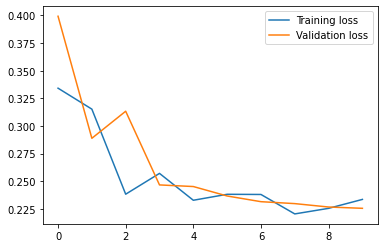

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 24ms/step - loss: 0.1855


0.1855475753545761

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

31/31 [==============================] - 3s 25ms/step


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


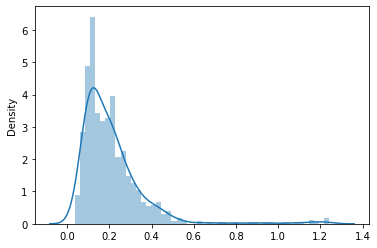

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
THRESHOLD = 0.4
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

7/7 [==============================] - 0s 15ms/step


In [ ]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].Close

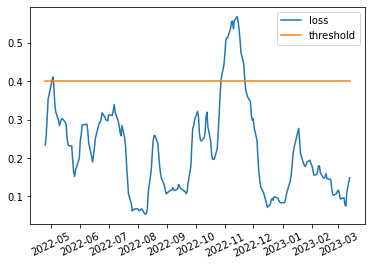

In [ ]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

It seems that we are effectively applying a threshold to filter out extreme values.

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
Date,,,,
2022-05-02,0.401326,0.4,True,-0.126250
2022-05-03,0.411107,0.4,True,-0.016045
2022-10-28,0.405672,0.4,True,0.114236
2022-10-31,0.442604,0.4,True,0.105693
2022-11-01,0.470982,0.4,True,0.202657


In [ ]:
anomalies_close = anomalies[["close"]].values.flatten()
anomalies_close = anomalies_close.reshape(-1, 1) # Reshape to a 2D array with one 
anomalies_close = scaler.inverse_transform(anomalies_close)

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


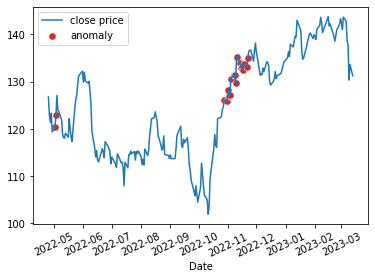

In [ ]:
plt.plot(
test[TIME_STEPS:].index,
scaler.inverse_transform(test[TIME_STEPS:][["Close"]]),
label='close price'
);
# convert it to a 1D array for the plot
anomalies_close = anomalies_close.flatten()
sns.scatterplot(
anomalies.index,
anomalies_close,
color=sns.color_palette()[3],
s=52,
label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

### Interpretation: It is important to carefully examine the chart.The anomalies, represented by the red dots, seem to be present mainly in areas where there are sudden changes in the closing price

# Predicting the closing price stock price of JP Morgan chase

In [4]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

1196

In [16]:
# Scale the data

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:11]

array([[0.38727761],
       [0.3904043 ],
       [0.39256068],
       [0.38274933],
       [0.38393531],
       [0.38501347],
       [0.33336925],
       [0.30167119],
       [0.33725066],
       [0.31417789],
       [0.31234502]])

In [19]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    #if i<= 61:
    #    print(x_train)
    #    print(y_train)
    #    print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1136, 60, 1)

In [24]:
len(x_train[0][0])

1

In [20]:
 #Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1136/1136 [==============================] - 27s 21ms/step - loss: 0.0042


In [27]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 1s 23ms/step


5.2583989752119535

<ipython-input-28-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


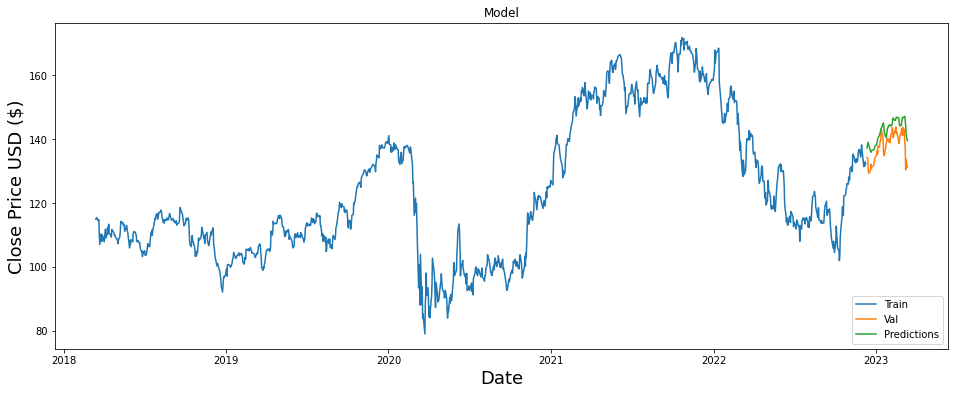

In [28]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [29]:
valid

,Close,Predictions
Date,,
2022-12-12,134.210007,137.203857
2022-12-13,134.080002,137.915497
2022-12-14,133.410004,138.620239
2022-12-15,130.100006,138.941101
2022-12-16,129.289993,138.131439
...,...,...
2023-03-07,138.619995,147.119858
2023-03-08,137.800003,145.972672
2023-03-09,130.339996,144.509033
